In [1]:
# Activations & Gradients, BatchNorm

# https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part3_bn.ipynb
# https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


#### Set Up
##### as before

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) # * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) #* 0.01  # scale the weight close to zero (not exactly zero because: )
b2 = torch.randn(vocab_size,                      generator=g) #* 0  # for initialization the bias shoud be zero (or equal) -> assumption: uniform distribution of all the characters


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 27.8817
  10000/ 200000: 2.9184
  20000/ 200000: 2.5847
  30000/ 200000: 2.7859
  40000/ 200000: 2.0222
  50000/ 200000: 2.6171
  60000/ 200000: 2.3168
  70000/ 200000: 2.0853
  80000/ 200000: 2.2519
  90000/ 200000: 2.2718
 100000/ 200000: 2.0234
 110000/ 200000: 2.4689
 120000/ 200000: 1.9426
 130000/ 200000: 2.3817
 140000/ 200000: 2.3213
 150000/ 200000: 2.1416
 160000/ 200000: 2.2320
 170000/ 200000: 1.7736
 180000/ 200000: 2.0826
 190000/ 200000: 1.8465


In [8]:
#plt.plot(lossi)

In [9]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h =torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  return loss.item()

split_loss('train')
split_loss('val')
tracking_stats = ['Model 1',split_loss('train'),split_loss('val')]

train 2.1276261806488037
val 2.1701834201812744
train 2.1276261806488037
val 2.1701834201812744


In [10]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mona.
mayah.
seel.
nah.
yam.
rethrsonngramira.
eredielin.
shy.
jen.
eden.
estanaraelyn.
malka.
cayshubergihamier.
kendreelynn.
nochorius.
mace.
ryyah.
fael.
yumaje.
sanyah.


### Multiple things are wrong with the modeL:
##### a. First loglikelihood is very high: what initial loss would you expect? given a uniform distribution
##### So at initialization we should plug in a uniform distribution, so every character is equally likely
##### -> this means setting b2 to zero
##### -> setting W2 close to zero: multiply by 0.01 or so: why not set it to zero?

In [11]:
# expected probability is 1/27
-torch.tensor(1.0/27.0).log()

tensor(3.2958)

In [12]:
logits = torch.tensor([7.0,-4.0,1.0,0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print("Very high loss:", loss.item(), " given the probabilities:", probs)

Very high loss: 6.003401279449463  given the probabilities: tensor([9.9660e-01, 1.6645e-05, 2.4703e-03, 9.0879e-04])


In [13]:
logits = torch.tensor([0.0,0.0,0.0,0.0]) # should be set to equal in the initialization
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print("First guess of the loss would be:", loss.item(), "given probs:", probs)

First guess of the loss would be: 1.3862943649291992 given probs: tensor([0.2500, 0.2500, 0.2500, 0.2500])


#### so here is the reviseted code: b2 = b2 * 0; W2 = W2 * 0.01

In [14]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) # * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01  # scale the weight close to zero (not exactly zero because: )
b2 = torch.randn(vocab_size,                      generator=g) * 0  # for initialization the bias shoud be zero (or equal) -> assumption: uniform distribution of all the characters


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
  
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])
11897
      0/ 200000: 3.3148
  10000/ 200000: 2.6505
  20000/ 200000: 2.4705
  30000/ 200000: 2.0266
  40000/ 200000: 2.1797
  50000/ 200000: 2.4072
  60000/ 200000: 2.2316
  70000/ 200000: 2.0701
  80000/ 200000: 2.0010
  90000/ 200000: 2.0439
 100000/ 200000: 2.4564
 110000/ 200000: 2.2124
 120000/ 200000: 2.1843
 130000/ 200000: 2.2414
 140000/ 200000: 2.1447
 150000/ 200000: 2.2837
 160000/ 200000: 2.0286
 170000/ 200000: 2.0146
 180000/ 200000: 2.2178
 190000/ 200000: 2.0372


In [15]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h =torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  return loss.item()

split_loss('train')
split_loss('val')
tracking_stats = tracking_stats , ['Model 2:  b2*0; W2=W2*0.01',split_loss('train'),split_loss('val')]
tracking_stats

train 2.069324493408203
val 2.133209228515625
train 2.069324493408203
val 2.133209228515625


(['Model 1', 2.1276261806488037, 2.1701834201812744],
 ['Model 2:  b2*0; W2=W2*0.01', 2.069324493408203, 2.133209228515625])

In [16]:
#plt.plot(lossi)

### b. Solved loss with respect to logits, BUT Still a problem with initialization 
#### look at values of h (activations of hidden states) -> many values are 1 or -1

In [17]:
# Preactivation
#plt.hist(hpreact.view(-1).tolist(), bins=50)

In [18]:
# Activation
#plt.hist(h.view(-1).tolist(), bins=50)

### This is problematic!

#### depending on the function where you have flat areas (as in tanh), the neurons could by chance end up to be 1 and -1 (or 1 and 0). So these neurons never learn: permanent brain damage in the neural net

In [19]:
# Create a distirbution with a larger variance (mean = zero)
a = torch.empty(10000).normal_(mean=0,std=1.5)
#plt.hist(a.view(-1).tolist(), bins=50)

In [20]:
a2 = torch.tanh(a)
#plt.hist(a2.view(-1).tolist(), bins=50)

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])
11897
      0/ 200000: 3.2959
  10000/ 200000: 1.8335
  20000/ 200000: 1.9758
  30000/ 200000: 2.4127
  40000/ 200000: 2.5336
  50000/ 200000: 1.8456
  60000/ 200000: 2.4327
  70000/ 200000: 2.0982
  80000/ 200000: 1.8181
  90000/ 200000: 2.2853
 100000/ 200000: 2.1659
 110000/ 200000: 2.2114
 120000/ 200000: 2.0398
 130000/ 200000: 1.8429
 140000/ 200000: 2.2416
 150000/ 200000: 2.1392
 160000/ 200000: 1.8348
 170000/ 200000: 2.1022
 180000/ 200000: 2.5763
 190000/ 200000: 1.8410


(array([587., 110.,  46.,  55.,  37.,  31.,  38.,  33.,  26.,  36.,  26.,
         32.,  24.,  29.,  41.,  45.,  37.,  55.,  73.,  83., 138., 228.,
        296., 455., 615., 627., 423., 284., 207., 141., 139.,  64.,  73.,
         31.,  26.,  36.,  34.,  22.,  28.,  38.,  39.,  19.,  35.,  34.,
         37.,  51.,  54.,  59., 102., 621.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

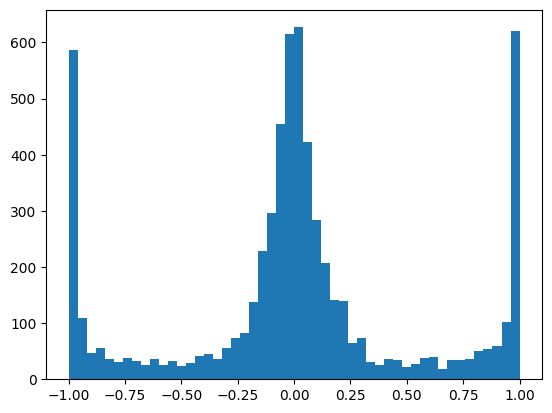

In [21]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.01
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01  # scale the weight close to zero (not exactly zero because: )
b2 = torch.randn(vocab_size,                      generator=g) * 0  # for initialization the bias shoud be zero (or equal) -> assumption: uniform distribution of all the characters


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
  
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

# Activation
plt.hist(h.view(-1).tolist(), bins=50)

In [22]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h =torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

tracking_stats = tracking_stats , ['Model 3:  W1=0.01; b2=0; W2=W2*0.01',split_loss('train'),split_loss('val')]
tracking_stats

train 2.1016416549682617
val 2.151332139968872
train 2.1016416549682617
val 2.151332139968872


((['Model 1', 2.1276261806488037, 2.1701834201812744],
  ['Model 2:  b2*0; W2=W2*0.01', 2.069324493408203, 2.133209228515625]),
 ['Model 3:  W1=0.01; b2=0; W2=W2*0.01', None, None])

### This Problem gets worse, when you have more layers
#### What is the value you should multiply W with to preserve a standard deviation of 1 for hpreact = embcat @ W1 + b1

In [23]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(f'Mean x: {x.mean():.6f}, Std x: {x.std():.6f}')
print(f'Mean w: {w.mean():.6f}, Std w: {w.std():.6f}')
print(f'Mean y: {y.mean():.6f}, Std y: {y.std():.6f}')

Mean x: -0.006351, Std x: 0.993653
Mean w: -0.008941, Std w: 0.990991
Mean y: 0.004615, Std y: 3.111047


#### Answer: * 1 / (10**0.5)
#### We should also add a gain: multiply by (5/3) divide by fan_mode. no clue why
#### So: * (5/3)/((n_embd * block_size)**0.5) #* 0.2

In [24]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(f'Mean x: {x.mean():.6f}, Std x: {x.std():.6f}')
print(f'Mean w: {w.mean():.6f}, Std w: {w.std():.6f}')
print(f'Mean y: {y.mean():.6f}, Std y: {y.std():.6f}')

Mean x: 0.002125, Std x: 1.001333
Mean w: 0.019494, Std w: 0.313731
Mean y: 0.000415, Std y: 0.994693


In [25]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * (5/3) / 30**0.5
y = x @ w
print(f'Mean x: {x.mean():.6f}, Std x: {x.std():.6f}')
print(f'Mean w: {w.mean():.6f}, Std w: {w.std():.6f}')
print(f'Mean y: {y.mean():.6f}, Std y: {y.std():.6f}')

Mean x: -0.002520, Std x: 0.999163
Mean w: -0.005806, Std w: 0.302183
Mean y: 0.003868, Std y: 0.952729


torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])
11897
      0/ 200000: 3.2919
  10000/ 200000: 2.3768
  20000/ 200000: 2.2040
  30000/ 200000: 2.1786
  40000/ 200000: 2.0913
  50000/ 200000: 2.0421
  60000/ 200000: 1.9533
  70000/ 200000: 2.2160
  80000/ 200000: 1.9515
  90000/ 200000: 2.0229
 100000/ 200000: 1.8909
 110000/ 200000: 1.8692
 120000/ 200000: 2.0451
 130000/ 200000: 2.0751
 140000/ 200000: 1.7027
 150000/ 200000: 2.0493
 160000/ 200000: 1.6198
 170000/ 200000: 1.7937
 180000/ 200000: 2.1341
 190000/ 200000: 1.7599


(array([1112.,  188.,  152.,  118.,  115.,   94.,   81.,   65.,   63.,
          51.,   45.,   50.,   65.,   54.,   69.,   59.,   64.,   62.,
          81.,  100.,   83.,   78.,   57.,  123.,  111.,   67.,  112.,
          82.,   64.,   74.,   86.,   71.,   64.,   54.,   49.,   48.,
          49.,   55.,   79.,   45.,   68.,   80.,   80.,   97.,   83.,
         106.,  131.,  170.,  255., 1191.]),
 array([-9.99999881e-01, -9.59999884e-01, -9.19999888e-01, -8.79999892e-01,
        -8.39999895e-01, -7.99999899e-01, -7.59999902e-01, -7.19999906e-01,
        -6.79999909e-01, -6.39999913e-01, -5.99999917e-01, -5.59999920e-01,
        -5.19999924e-01, -4.79999927e-01, -4.39999931e-01, -3.99999934e-01,
        -3.59999938e-01, -3.19999942e-01, -2.79999945e-01, -2.39999949e-01,
        -1.99999952e-01, -1.59999956e-01, -1.19999959e-01, -7.99999630e-02,
        -3.99999666e-02,  2.98023223e-08,  4.00000262e-02,  8.00000226e-02,
         1.20000019e-01,  1.60000015e-01,  2.00000012e-01,  2.400000

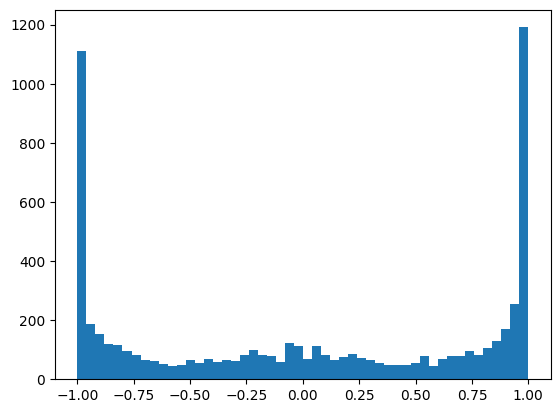

In [26]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01  # scale the weight close to zero (not exactly zero because: )
b2 = torch.randn(vocab_size,                      generator=g) * 0  # for initialization the bias shoud be zero (or equal) -> assumption: uniform distribution of all the characters


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
  
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

# Activation: still looks bad though....
plt.hist(h.view(-1).tolist(), bins=50)

In [27]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h =torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


tracking_stats = tracking_stats , ['Model 4:  W1=(5/3)/((n_embd * block_size)**0.5); b2=0; W2=W2*0.01',split_loss('train'),split_loss('val')]
tracking_stats

train 2.036036491394043
val 2.109381675720215
train 2.036036491394043
val 2.109381675720215


(((['Model 1', 2.1276261806488037, 2.1701834201812744],
   ['Model 2:  b2*0; W2=W2*0.01', 2.069324493408203, 2.133209228515625]),
  ['Model 3:  W1=0.01; b2=0; W2=W2*0.01', None, None]),
 ['Model 4:  W1=(5/3)/((n_embd * block_size)**0.5); b2=0; W2=W2*0.01',
  None,
  None])

### Batch Normalization
#### We want the preactivation function not procuding values that are very small (tanh produces -1) neither way too large (tanh produces ones)
#### We want them to be roughly Gaussian: subtract mean divide by standard deviation
#### Addtionally to batch normalization: we want the network not to be forced to be Gaussian. So we want it to be able to shift and deviate from that distribution

In [28]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01  # scale the weight close to zero (not exactly zero because: )
b2 = torch.randn(vocab_size,                      generator=g) * 0  # for initialization the bias shoud be zero (or equal) -> assumption: uniform distribution of all the characters

# Addtionally to batch normalization: we want the network not to be forced to be Gaussian
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))


parameters = [C, W1, b1, W2, b2, bngain, bngain]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
  
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1
 
 
  # Batch Normalization NEW
  hpreact = bngain * (hpreact-hpreact.mean(0, keepdim= True) / hpreact.std(0, keepdim= True) ) - bnbias
 
 
 
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])
12297
      0/ 200000: 3.2926
  10000/ 200000: 2.3681
  20000/ 200000: 1.7444
  30000/ 200000: 2.1972
  40000/ 200000: 2.0636
  50000/ 200000: 2.0787
  60000/ 200000: 1.9219
  70000/ 200000: 2.1091
  80000/ 200000: 2.1248
  90000/ 200000: 2.0234
 100000/ 200000: 2.0432
 110000/ 200000: 1.8459
 120000/ 200000: 2.0609
 130000/ 200000: 2.2648
 140000/ 200000: 1.8508
 150000/ 200000: 1.6568
 160000/ 200000: 1.8573
 170000/ 200000: 2.2071
 180000/ 200000: 1.7515
 190000/ 200000: 1.8627


In [29]:
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [30]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact-hpreact.mean(0, keepdim= True) / hpreact.std(0, keepdim= True) ) - bnbias
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

tracking_stats = tracking_stats , ['Model 5:  Batch Normalization',split_loss('train'),split_loss('val')]
tracking_stats

train 2.0489697456359863
val 2.1184422969818115
train 2.0489697456359863
val 2.1184422969818115


((((['Model 1', 2.1276261806488037, 2.1701834201812744],
    ['Model 2:  b2*0; W2=W2*0.01', 2.069324493408203, 2.133209228515625]),
   ['Model 3:  W1=0.01; b2=0; W2=W2*0.01', None, None]),
  ['Model 4:  W1=(5/3)/((n_embd * block_size)**0.5); b2=0; W2=W2*0.01',
   None,
   None]),
 ['Model 5:  Batch Normalization', None, None])

In [31]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mondalynn.
hegermed.
rhal.
remman.
brerleg.
adelynne.
hillyn.
jennedecklandraxleigh.
mcky.
adi.
shdynr.
shimier.
kindrenevionnicocen.
brence.
rhylene.
eli.
kayshawn.
lan.
hal.
sadyansh.


### what we have achieved so far:

Negative Loglikelihood
| Step | Train | Test |
| :- | -: | :-: |
| Standard | 2.1276 | 2.1701 |
| W2 * 0.01 and b2 * 0 | 2.2556 | 2.3397 |
| + W1 * 0.01 and b1 * 0.01 | 2.1016 | 2.1513 |
| equally distributed values and b1 * 0.01 | 2.1051 | 2.1384 |
| Improving Gradient | 2.0377 | 2.1032 |
| Batch Normalization | 2.0411 | 2.1137 |

### Batch normalization has a regulaizing effect

#### achieving gaussian distribution is easy in a neural network with just one layer, but gets more complicated the more layers there are involved

In [32]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01  # scale the weight close to zero (not exactly zero because: )
b2 = torch.randn(vocab_size,                      generator=g) * 0  # for initialization the bias shoud be zero (or equal) -> assumption: uniform distribution of all the characters

# Addtionally to batch normalization: we want the network not to be forced to be Gaussian
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running =  torch.ones((1, n_hidden))

bnmean_running2 = torch.zeros((1, n_hidden))
bnstd_running2 =  torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
  
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 # + b1 # because b1 gets canceled out during batch normalization!
 
 
  # Batch Normalization NEW
  bnmeani = hpreact.mean(0, keepdim= True)
  bnstdi = hpreact.std(0, keepdim= True) + 0.001  # add a small error so if the variance is zero, we are not running into troubles
  
  hpreact = bngain * (hpreact-bnmeani) / bnstdi - bnbias 
 
  with torch.no_grad():
    bnmean_running2 = (bnmean_running*i + bnmeani) / (i+1)
    bnstd_running2 = (bnstd_running*i + bnstdi) / (i+1)
    bnmean_running = 0.999 * bnmean_running2 + 0.001 * bnmeani  # running mean: because we are trying to estimate the mean of the whole dataset. With a small batch size higher values might be to sensitive for outliers. starting at mean zero we are estimating what the next batch would change
    bnstd_running = 0.999 * bnstd_running2 + 0.001 * bnstdi
   
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])
12097
      0/ 200000: 3.2835
  10000/ 200000: 2.4888
  20000/ 200000: 2.5556
  30000/ 200000: 2.3234
  40000/ 200000: 2.1004
  50000/ 200000: 2.4306
  60000/ 200000: 2.1232
  70000/ 200000: 1.7836
  80000/ 200000: 2.1853
  90000/ 200000: 2.1955
 100000/ 200000: 1.7435
 110000/ 200000: 1.9625
 120000/ 200000: 2.2277
 130000/ 200000: 2.0731
 140000/ 200000: 2.0738
 150000/ 200000: 1.9988
 160000/ 200000: 2.1839
 170000/ 200000: 2.4861
 180000/ 200000: 2.0557
 190000/ 200000: 2.0239


In [33]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact-hpreact.mean(0, keepdim= True) / hpreact.std(0, keepdim= True) ) - bnbias
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

tracking_stats = tracking_stats , ['Model 5:  Batch Normalization',split_loss('train'),split_loss('val')]
tracking_stats

train 2.3282535076141357
val 2.377671718597412
train 2.3282535076141357
val 2.377671718597412


(((((['Model 1', 2.1276261806488037, 2.1701834201812744],
     ['Model 2:  b2*0; W2=W2*0.01', 2.069324493408203, 2.133209228515625]),
    ['Model 3:  W1=0.01; b2=0; W2=W2*0.01', None, None]),
   ['Model 4:  W1=(5/3)/((n_embd * block_size)**0.5); b2=0; W2=W2*0.01',
    None,
    None]),
  ['Model 5:  Batch Normalization', None, None]),
 ['Model 5:  Batch Normalization', None, None])

In [ ]:
# Calibration for prediction
with torch.no_grad():
    emb = C[Xtr] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim= True)
    bnstd = hpreact.std(0, keepdim= True)

plt.scatter(bnstd_running, bnstd)

In [ ]:
print(bnmean_running2)

In [ ]:

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact-hpreact.mean(0, keepdim= True) / hpreact.std(0, keepdim= True) ) - bnbias
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

# Some Corrections

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01  # scale the weight close to zero (not exactly zero because: )
b2 = torch.randn(vocab_size,                      generator=g) * 0  # for initialization the bias shoud be zero (or equal) -> assumption: uniform distribution of all the characters
print(b2)
# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break